In [1]:
import pickle
import pandas as pd
import re
import numpy as np
from random import randrange
from datetime import timedelta
import statistics

In [2]:
donates_all = pd.read_csv('donates_all_22_12_22.csv')
print(donates_all.shape)
donates_all.head(2)

(2701, 28)


,channel_id,message_id,city,channel_name,date,message_text,donate,views,forwards,tmp_keyword,...,оптика,запчастини,зв'язок,амуніція,медицина,броня,засоби спостереження,БПЛА,зброя,мінна безпека
0,1149657308,92611,Kharkiv,Хуевый ✙ Харьков 🇺🇦,2022-12-18 09:00:54,🚨🚨✈️🚨🚨✈️🚨🚨\n\n!!!ДРУЗІ!!!\nТриває збір для моб...,320000,146934.0,2.0,збір коштів,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1149657308,91699,Kharkiv,Хуевый ✙ Харьков 🇺🇦,2022-12-11 14:02:13,Великий збір NATA& NO PANIC FOUNDATION на 3 пі...,425000,137933.0,1.0,збір коштів,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
list(pd.unique(donates_all['city']))

['Kharkiv',
 'Lviv',
 'Poltava',
 'Dnipropetrovsk',
 'Sumy',
 'Zaporizhzhia',
 'Kherson',
 'Mykolaiv',
 'Kyiv',
 'Ukraine']

### Remove duplicates by 'message_text' column

In [5]:
donates_all.drop_duplicates(subset = "message_text", keep = False, inplace = True) # (2701, 28)
print(donates_all.shape)

(2701, 28)


### Remove outliers

In [6]:
donates = list(set(donates_all['donate'].tolist()))
donates.sort(reverse=True)
print(donates[0:20])

[1425000000, 770007000, 723000000, 500000000, 488564664, 310000000, 206000000, 200000000, 150000000, 135000000, 120000000, 100000000, 80000000, 70000000, 67676767, 67600000, 60000000, 54000000, 50000122, 50000000]


All outliers were checked manually 

In [7]:
# the cleaned dataset
donates_all_clean = pd.read_csv('Number of volunteers by region - All_28_12_22.csv')
print(donates_all_clean.shape)

(2687, 29)


In [8]:
donates = list(set(donates_all_clean['donate'].tolist()))
donates.sort(reverse=True)
print(donates[0:20])

[2400000000, 2000000000, 206000000, 200000000, 150000000, 135000000, 120000000, 100000000, 80000000, 70000000, 54739500, 54000000, 50000000, 44865632, 43319371, 43000000, 35155000, 30000000, 29011993, 26081998]


In [9]:
print(list(donates_all_clean.columns))

['channel_id', 'message_id', 'city', 'channel_name', 'date', 'message_text', 'donate', 'views', 'forwards', 'tmp_keyword', 'tmp_possible_donates', 'ремонт', 'квадрокоптери', 'генератори і акумулятори', 'авто', "комп'ютерна та відео техніка", 'тепловізори, снайпінг, ПНБ', 'гуманітарна допомога', 'оптика', 'запчастини', "зв'язок", 'амуніція', 'медицина', 'броня', 'засоби спостереження', 'БПЛА', 'зброя', 'мінна безпека', 'загальні витрати']


In [10]:
donates_all_clean['DateTime']= pd.to_datetime(donates_all_clean['date'])

### General expenses include all rows where there is no price or products

In [11]:
# fill 'загальні витрати' column

column_id = donates_all_clean.columns.get_loc('загальні витрати')

num_lost_jeneral_expances = 0
for i in range(len(donates_all_clean)):
    donate = donates_all_clean.iloc[i]['donate']
    products_list = donates_all_clean.iloc[i][['ремонт', 'квадрокоптери', 'генератори і акумулятори', 
                               'авто', "комп'ютерна та відео техніка", 'тепловізори, снайпінг, ПНБ', 
                               'гуманітарна допомога', 'оптика', 'запчастини', "зв'язок", 'амуніція', 'медицина', 
                               'броня', 'засоби спостереження', 'БПЛА', 'зброя', 'мінна безпека', 
                                'загальні витрати']].tolist()[::]
    products_list = [el for el in products_list if ~np.isnan(el)]
    if (np.isnan(donate) | donate <= 0) & (sum(products_list) == 0):
        donates_all_clean.iat[i,column_id] = 1
        num_lost_jeneral_expances += 1
        
print(num_lost_jeneral_expances)

358


In [12]:
donates_all_clean['БПЛА'].fillna(0, inplace=True)
donates_all_clean['квадрокоптери'].fillna(0, inplace=True)

donates_all_clean['БПЛА'] = donates_all_clean['БПЛА'] + donates_all_clean['квадрокоптери']
donates_all_clean.drop(columns=['квадрокоптери'], inplace=True)

In [13]:
# convert Hrivna to US dollars
donates_all_clean['donate'] = donates_all_clean['donate'].apply(lambda x: x/40)

### Select posts before '2022-11-01'

In [14]:
donates_all_end = donates_all_clean[donates_all_clean['DateTime'] < '2022-11-01'].copy()
print(donates_all_end.shape)

(1946, 29)


In [15]:
donates_all_after = donates_all_clean[donates_all_clean['DateTime'] >= '2022-11-01'].copy()
print(donates_all_after.shape)

(741, 29)


In [16]:
def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = pd.to_datetime(end) - pd.to_datetime(start)
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return pd.to_datetime(start) + timedelta(seconds=random_second)

For posts after '2022-11-01' select random dates between '2022-02-24' and '2022-11-01'

In [17]:
donates_all_after['DateTime'] = donates_all_after['DateTime'].apply(lambda x: random_date('2022-02-24 06:00:00', '2022-11-01 00:00:00'))
donates_all_after['date'] = donates_all_after['DateTime'].dt.strftime('%Y-%m-%d %H:%M:%S')


### Calculate multipliers to remove script error

For 'Хуевый ✙ Харьков 🇺🇦' channel I manually collected Gold Dataset
Follow this link to find it 

https://docs.google.com/spreadsheets/d/1iPPVGVdd1Q1MzyD9LFWMbtzgkBUblvW2QtPzefZ3KI8/edit?usp=sharing

In [44]:
donates_all_end[donates_all_end['channel_name'] == 'Хуевый ✙ Харьков 🇺🇦'].shape

(121, 31)

In [19]:
gold_number_posts = 196
recall = 121/gold_number_posts
recall_multiplier = 1-recall+1
recall_multiplier

1.3826530612244898

The script loses about 38% of messages.

In [20]:
# donates in the USA $
donates_all_end[donates_all_end['channel_name'] == 'Хуевый ✙ Харьков 🇺🇦']['donate'].sum() 

2449878.55

In [21]:
gold_sum_of_donates = 3674815.75
money_multiplier = (gold_sum_of_donates - 2449878.55)/gold_sum_of_donates + 1
money_multiplier

1.3333329568972268

In [22]:
products_series = donates_all_end[donates_all_end['channel_name'] == 'Хуевый ✙ Харьков 🇺🇦'][['ремонт', 'генератори і акумулятори', 
                               'авто', "комп'ютерна та відео техніка", 'тепловізори, снайпінг, ПНБ', 
                               'гуманітарна допомога', 'оптика', 'запчастини', "зв'язок", 'амуніція', 'медицина', 
                               'броня', 'засоби спостереження', 'БПЛА', 'зброя', 'мінна безпека', 
                                'загальні витрати']].sum(axis=0)
products_series

ремонт                             7.0
генератори і акумулятори          90.0
авто                              57.0
комп'ютерна та відео техніка      11.0
тепловізори, снайпінг, ПНБ       106.0
гуманітарна допомога              16.0
оптика                            13.0
запчастини                         4.0
зв'язок                          117.0
амуніція                         835.0
медицина                         363.0
броня                            211.0
засоби спостереження               3.0
БПЛА                            1123.0
зброя                              4.0
мінна безпека                      2.0
загальні витрати                   8.0
dtype: float64

In [23]:
gold_repair = 42
repair_multiplier = abs(products_series.loc['ремонт'] - gold_repair)/products_series.loc['ремонт'] + 1
print('repair_multiplier =', repair_multiplier)

gold_auto = 155
auto_multiplier = abs(products_series.loc['авто'] - gold_auto)/products_series.loc['авто'] + 1
print('auto_multiplier =', auto_multiplier)

gold_thermal_imagers = 350 
thermal_imagers_multiplier = abs(products_series.loc['тепловізори, снайпінг, ПНБ'] - gold_thermal_imagers)/products_series.loc['тепловізори, снайпінг, ПНБ'] + 1
print('thermal_imagers_multiplier =', thermal_imagers_multiplier)

gold_humanitarian = 37
humanitarian_multiplier = abs(products_series.loc['гуманітарна допомога'] - gold_humanitarian)/products_series.loc['гуманітарна допомога'] + 1
print('humanitarian_multiplier =', humanitarian_multiplier)

gold_communication = 141
communication_multiplier = abs(products_series.loc["зв'язок"] - gold_communication)/products_series.loc["зв'язок"] + 1
print('communication_multiplier =', communication_multiplier)

gold_ammunition = 2318
ammunition_multiplier = abs(products_series.loc['амуніція'] - gold_ammunition)/products_series.loc['амуніція'] + 1
print('ammunition_multiplier =', ammunition_multiplier)

gold_medicine = 508
medicine_multiplier = abs(products_series.loc['медицина'] - gold_medicine)/products_series.loc['медицина'] + 1
print('medicine_multiplier =', medicine_multiplier)

gold_armor = 736
armor_multiplier = abs(products_series.loc['броня'] - gold_armor)/products_series.loc['броня'] + 1
print('armor_multiplier =', armor_multiplier)

gold_weapons = 7
weapons_multiplier = abs(products_series.loc['зброя'] - gold_weapons)/products_series.loc['зброя'] + 1
print('weapons_multiplier =', weapons_multiplier)

gold_mine_safety = 85
mine_safety_multiplier = abs(products_series.loc['мінна безпека'] - gold_mine_safety)/products_series.loc['мінна безпека'] + 1
print('mine_safety_multiplier =', mine_safety_multiplier)


repair_multiplier = 6.0
auto_multiplier = 2.719298245614035
thermal_imagers_multiplier = 3.30188679245283
humanitarian_multiplier = 2.3125
communication_multiplier = 1.205128205128205
ammunition_multiplier = 2.776047904191617
medicine_multiplier = 1.399449035812672
armor_multiplier = 3.4881516587677726
weapons_multiplier = 1.75
mine_safety_multiplier = 42.5


! no multiplier for БПЛА, генератори і акумулятори, оптика

### Apply multipliers to remove script error

In [24]:
# Apply multiplier for money
donates_all_end['donate'] = donates_all_end['donate'].apply(lambda x: x * money_multiplier if x != 'Ukraine' else x)
donates_all_end['donate'] = donates_all_end['donate'].apply(lambda x: x * money_multiplier if x != 'Ukraine' else x)

# Apply multiplier for repair
donates_all_end['ремонт'] = donates_all_end['ремонт'] * repair_multiplier
donates_all_after['ремонт'] = donates_all_after['ремонт'] * repair_multiplier

# Apply multiplier for auto
donates_all_end['авто'] = donates_all_end['авто'] * auto_multiplier
donates_all_after['авто'] = donates_all_after['авто'] * auto_multiplier

# Apply multiplier for thermal_imagers
donates_all_end['тепловізори, снайпінг, ПНБ'] = donates_all_end['тепловізори, снайпінг, ПНБ'] * thermal_imagers_multiplier
donates_all_after['тепловізори, снайпінг, ПНБ'] = donates_all_after['тепловізори, снайпінг, ПНБ'] * thermal_imagers_multiplier

# Apply multiplier for humanitarian
donates_all_end['гуманітарна допомога'] = donates_all_end['гуманітарна допомога'] * humanitarian_multiplier
donates_all_after['гуманітарна допомога'] = donates_all_after['гуманітарна допомога'] * humanitarian_multiplier

# Apply multiplier for communication
donates_all_end["зв'язок"] = donates_all_end["зв'язок"] * communication_multiplier
donates_all_after["зв'язок"] = donates_all_after["зв'язок"] * communication_multiplier

# Apply multiplier for ammunition
donates_all_end['амуніція'] = donates_all_end['амуніція'] * ammunition_multiplier
donates_all_after['амуніція'] = donates_all_after['амуніція'] * ammunition_multiplier

# Apply multiplier for medicine
donates_all_end['медицина'] = donates_all_end['медицина'] * medicine_multiplier
donates_all_after['медицина'] = donates_all_after['медицина'] * medicine_multiplier

# Apply multiplier for armor
donates_all_end['броня'] = donates_all_end['броня'] * armor_multiplier
donates_all_after['броня'] = donates_all_after['броня'] * armor_multiplier

# Apply multiplier for weapons
donates_all_end['зброя'] = donates_all_end['зброя'] * weapons_multiplier
donates_all_after['зброя'] = donates_all_after['зброя'] * weapons_multiplier

# Apply multiplier for mine_safety
donates_all_end['мінна безпека'] = donates_all_end['мінна безпека'] * mine_safety_multiplier
donates_all_after['мінна безпека'] = donates_all_after['мінна безпека'] * mine_safety_multiplier

### Apply the quantity multiplier to calculate the correct price by products 

In [25]:
def quantity_multiplier(value, threshold, multiplier):
    if np.isnan(value):
        return value
    else:
        if value <= threshold:
            return value
        else:
            return value*multiplier

In [26]:
# computer and video equipment | if value <5 multiply by 10
donates_all_end["комп'ютерна та відео техніка"] = donates_all_end["комп'ютерна та відео техніка"].apply(lambda x: quantity_multiplier(x, 5, 10))
donates_all_after["комп'ютерна та відео техніка"] = donates_all_after["комп'ютерна та відео техніка"].apply(lambda x: quantity_multiplier(x, 5, 10))

# thermal_imagers | if value <7 multiply by 5
donates_all_end['тепловізори, снайпінг, ПНБ'] = donates_all_end['тепловізори, снайпінг, ПНБ'].apply(lambda x: quantity_multiplier(x, 7, 5))
donates_all_after['тепловізори, снайпінг, ПНБ'] = donates_all_after['тепловізори, снайпінг, ПНБ'].apply(lambda x: quantity_multiplier(x, 7, 5))

# optics | if value <5 multiply by 3
donates_all_end['оптика'] = donates_all_end['оптика'].apply(lambda x: quantity_multiplier(x, 5, 3))
donates_all_after['оптика'] = donates_all_after['оптика'].apply(lambda x: quantity_multiplier(x, 5, 3))

# communication | if value <5 multiply by 10
donates_all_end["зв'язок"] = donates_all_end["зв'язок"].apply(lambda x: quantity_multiplier(x, 5, 10))
donates_all_after["зв'язок"] = donates_all_after["зв'язок"].apply(lambda x: quantity_multiplier(x, 5, 10))

# ammunition | if value <10 multiply by  25
donates_all_end["амуніція"] = donates_all_end["амуніція"].apply(lambda x: quantity_multiplier(x, 10, 25))
donates_all_after["амуніція"] = donates_all_after["амуніція"].apply(lambda x: quantity_multiplier(x, 10, 25))

# medicine | if value <10 multiply by  30
donates_all_end["медицина"] = donates_all_end["медицина"].apply(lambda x: quantity_multiplier(x, 10, 30))
donates_all_after["медицина"] = donates_all_after["медицина"].apply(lambda x: quantity_multiplier(x, 10, 30))

# armor | if value <10 multiply by  15
donates_all_end["броня"] = donates_all_end["броня"].apply(lambda x: quantity_multiplier(x, 10, 15))
donates_all_after["броня"] = donates_all_after["броня"].apply(lambda x: quantity_multiplier(x, 10, 15))

# mine_safety | if value < 25 multiply by  15
donates_all_end["мінна безпека"] = donates_all_end["мінна безпека"].apply(lambda x: quantity_multiplier(x, 25, 15))
donates_all_after["мінна безпека"] = donates_all_after["мінна безпека"].apply(lambda x: quantity_multiplier(x, 25, 15))

### Calculate the approximate cost of products in dollars

In [27]:
donates_all_end['products_cost'] = 0
donates_all_after['products_cost'] = 0

# money equivalent of 1 item, $
prices_dict = {'ремонт':60, 'генератори і акумулятори': 300, 'авто':5000, "комп'ютерна та відео техніка":125,
              'тепловізори, снайпінг, ПНБ': 2000, 'гуманітарна допомога': 1000, 'оптика':450, 'запчастини':50,
              "зв'язок":750, 'амуніція':60, 'медицина':75, 'броня':350, 'засоби спостереження':1000, 'БПЛА':2825,
              'зброя':10000, 'мінна безпека':500, 'загальні витрати':2000}

col_names = ['ремонт', 'генератори і акумулятори', 'авто', "комп'ютерна та відео техніка", 'тепловізори, снайпінг, ПНБ', 
             'гуманітарна допомога', 'оптика', 'запчастини', "зв'язок", 'амуніція', 'медицина', 'броня', 'засоби спостереження', 
             'БПЛА', 'зброя', 'мінна безпека', 'загальні витрати']

column_id = donates_all_end.columns.get_loc('products_cost')
for i in range(len(donates_all_end)):
    products_cost = 0
    for col in col_names:
        price = prices_dict[col]
        amount = donates_all_clean.iloc[i][col]
        if ~np.isnan(amount):
            products_cost += price*amount
    donates_all_end.iat[i,column_id] = products_cost
    
column_id = donates_all_after.columns.get_loc('products_cost')
for i in range(len(donates_all_after)):
    products_cost = 0
    for col in col_names:
        price = prices_dict[col]
        amount = donates_all_after.iloc[i][col]
        if ~np.isnan(amount):
            products_cost += price*amount
    donates_all_after.iat[i,column_id] = products_cost

##### Calcilate final donate = 25% donate + 75% products_cost 

In [42]:
donates_all_end['donate'].fillna(0, inplace=True)
donates_all_after['donate'].fillna(0, inplace=True)
donates_all_end['final_donate'] = 0
donates_all_after['final_donate'] = 0

column_id = donates_all_end.columns.get_loc('final_donate')
for i in range(len(donates_all_end)):
    donate = donates_all_end.iloc[i]['donate']
    products_cost = donates_all_end.iloc[i]['products_cost']
    if (donate>0) & (products_cost > 0):
        donates_all_end.iat[i,column_id] = donate*0.25 + products_cost*0.75
    elif (donate==0) & (products_cost > 0):
        donates_all_end.iat[i,column_id] = products_cost
    elif (donate>0) & (products_cost == 0):
        donates_all_end.iat[i,column_id] = donate
        
column_id = donates_all_after.columns.get_loc('final_donate')
for i in range(len(donates_all_after)):
    donate = donates_all_after.iloc[i]['donate']
    products_cost = donates_all_after.iloc[i]['products_cost']
    if (donate>0) & (products_cost > 0):
        donates_all_after.iat[i,column_id] = donate*0.25 + products_cost*0.75
    elif (donate==0) & (products_cost > 0):
        donates_all_after.iat[i,column_id] = products_cost
    elif (donate>0) & (products_cost == 0):
        donates_all_after.iat[i,column_id] = donate

### Randomly select 38% of the messages and add them to the data set for each existing regions

In [43]:
# number of messages from '2022-02-24' to '2022-11-01'
donates_all_end.groupby(['city'])['city'].count()

city
Dnipropetrovsk    148
Kharkiv           192
Kherson            16
Kyiv              294
Lviv              327
Mykolaiv          106
Poltava           110
Sumy              101
Ukraine           601
Zaporizhzhia       51
Name: city, dtype: int64

In [48]:
# Dnipro
num_Dnipro = donates_all_end.groupby(['city'])['city'].count().loc['Dnipropetrovsk']
num_Dnipro = int(round(num_Dnipro*0.38, 0))
print("num_Dnipro = ", num_Dnipro)

# Kyiv + Kyiv oblast
num_Kyiv = donates_all_end.groupby(['city'])['city'].count().loc['Kyiv']
num_Kyiv = int(round(num_Kyiv*0.38, 0))
print("num_Kyiv = ", num_Kyiv)

# Kharkiv
num_Kharkiv = donates_all_end.groupby(['city'])['city'].count().loc['Kharkiv']
num_Kharkiv = int(round(num_Kharkiv*0.38, 0))
print("num_Kharkiv = ", num_Kharkiv)

# Lviv
num_Lviv = donates_all_end.groupby(['city'])['city'].count().loc['Lviv']
num_Lviv = int(round(num_Lviv*0.38, 0))
print("num_Lviv = ", num_Lviv)

# Mykolaiv
num_Mykolaiv = donates_all_end.groupby(['city'])['city'].count().loc['Mykolaiv']
num_Mykolaiv = int(round(num_Mykolaiv*0.38, 0))
print("num_Mykolaiv = ", num_Mykolaiv)

# Poltava
num_Poltava = donates_all_end.groupby(['city'])['city'].count().loc['Poltava']
num_Poltava = int(round(num_Poltava*0.38, 0))
print("num_Poltava = ", num_Poltava)

# Sumy
num_Sumy = donates_all_end.groupby(['city'])['city'].count().loc['Sumy']
num_Sumy = int(round(num_Sumy*0.38, 0))
print("num_Sumy = ", num_Sumy)

# Zaporizhzhia
num_Zaporizhzhia = donates_all_end.groupby(['city'])['city'].count().loc['Zaporizhzhia']
num_Zaporizhzhia = int(round(num_Zaporizhzhia*0.38, 0))
print("num_Zaporizhzhia = ", num_Zaporizhzhia)

# Ukraine
num_Ukraine = donates_all_end.groupby(['city'])['city'].count().loc['Ukraine']
num_Ukraine = int(round(num_Ukraine*0.38, 0))
print("num_Ukraine = ", num_Ukraine)

num_Dnipro =  56
num_Kyiv =  112
num_Kharkiv =  73
num_Lviv =  124
num_Mykolaiv =  40
num_Poltava =  42
num_Sumy =  38
num_Zaporizhzhia =  19
num_Ukraine =  228


We can add posts after 01/11/2022 

In [49]:
# number of messages after '2022-11-01'
donates_all_after.groupby(['city'])['city'].count()

city
Dnipropetrovsk      8
Kharkiv           101
Kherson            11
Kyiv               58
Lviv              130
Mykolaiv           22
Poltava            33
Sumy                9
Ukraine           360
Zaporizhzhia        9
Name: city, dtype: int64

In [50]:
# Dnipro have 8 need 56
dnipro_after_df = donates_all_after[donates_all_after['city']=='Dnipropetrovsk'].copy() # 8
dnipro_addon_df = donates_all_end[donates_all_end['city'] != 'Ukraine'].sample(n=num_Dnipro-8, random_state=1).copy() 
dnipro_df =  pd.concat([dnipro_after_df, dnipro_addon_df])
dnipro_df = dnipro_df.reset_index(drop=True)
print('Dnipro', dnipro_df.shape[0] == num_Dnipro)

# Kharkiv have 101 need 73
kharkiv_df = donates_all_after[donates_all_after['city']=='Kharkiv'].sample(n=num_Kharkiv, random_state=1).copy() # 73
kharkiv_df = kharkiv_df.reset_index(drop=True)
print('Kharkiv', kharkiv_df.shape[0] == num_Kharkiv)

# Kyiv + Kyiv oblast have 58 need 112
kyiv_after_df = donates_all_after[donates_all_after['city']=='Kyiv'].copy() # 58
kyiv_addon_df = donates_all_end[donates_all_end['city'] != 'Ukraine'].sample(n=num_Kyiv-58, random_state=1).copy() 
kyiv_df =  pd.concat([kyiv_after_df, kyiv_addon_df])
kyiv_df = kyiv_df.reset_index(drop=True)
print('Kyiv + Kyiv oblast', kyiv_df.shape[0] == num_Kyiv)

# Lviv have 130 need 124
lviv_df = donates_all_after[donates_all_after['city']=='Lviv'].sample(n=num_Lviv, random_state=1).copy() # 124
lviv_df = lviv_df.reset_index(drop=True)
print('Lviv', lviv_df.shape[0] == num_Lviv)

# Mykolaiv have 22 need 40 
mykolaiv_after_df = donates_all_after[donates_all_after['city']=='Mykolaiv'].copy() # 22
mykolaiv_addon_df = donates_all_end[donates_all_end['city'] != 'Ukraine'].sample(n=num_Mykolaiv-22, random_state=1).copy() 
mykolaiv_df =  pd.concat([mykolaiv_after_df, mykolaiv_addon_df])
mykolaiv_df = mykolaiv_df.reset_index(drop=True)
print('Mykolaiv', mykolaiv_df.shape[0] == num_Mykolaiv)

# Poltava have 33 need 42
poltava_after_df = donates_all_after[donates_all_after['city']=='Poltava'].copy() # 33
poltava_addon_df = donates_all_end[donates_all_end['city'] != 'Ukraine'].sample(n=num_Poltava-33, random_state=1).copy() 
poltava_df =  pd.concat([poltava_after_df, poltava_addon_df])
poltava_df = poltava_df.reset_index(drop=True)
print('Poltava', poltava_df.shape[0] == num_Poltava)

# Sumy have 9 need 38
sumy_after_df = donates_all_after[donates_all_after['city']=='Sumy'].copy() # 9
sumy_addon_df = donates_all_end[donates_all_end['city'] != 'Ukraine'].sample(n=num_Sumy-9, random_state=1).copy() 
sumy_df =  pd.concat([sumy_after_df, sumy_addon_df])
sumy_df = sumy_df.reset_index(drop=True)
print('Sumy', sumy_df.shape[0] == num_Sumy)

# Zaporizhzhia have 9 need 19
zaporizhzhia_after_df = donates_all_after[donates_all_after['city']=='Zaporizhzhia'].copy() # 9
zaporizhzhia_addon_df = donates_all_end[donates_all_end['city'] != 'Ukraine'].sample(n=num_Zaporizhzhia-9, random_state=1).copy() 
zaporizhzhia_df =  pd.concat([zaporizhzhia_after_df, zaporizhzhia_addon_df])
zaporizhzhia_df = zaporizhzhia_df.reset_index(drop=True)
print('Zaporizhzhia', zaporizhzhia_df.shape[0] == num_Zaporizhzhia)

# Ukraine have 360 need 228
ukraine_df = donates_all_after[donates_all_after['city']=='Ukraine'].sample(n=num_Ukraine, random_state=1).copy() # 228
ukraine_df = ukraine_df.reset_index(drop=True)
print('Ukraine', ukraine_df.shape[0] == num_Ukraine)

Dnipro True
Kharkiv True
Kyiv + Kyiv oblast True
Lviv True
Mykolaiv True
Poltava True
Sumy True
Zaporizhzhia True
Ukraine True


In [51]:
existing_regions = [donates_all_end, dnipro_df, kharkiv_df, kyiv_df, lviv_df, mykolaiv_df, poltava_df, 
                    sumy_df, zaporizhzhia_df, ukraine_df]
final_part1_df = pd.concat(existing_regions)
final_part1_df = final_part1_df.reset_index(drop=True)
final_part1_df.shape

(2678, 31)

### Define number of post for other Ukrainian regions by Population (2021 estimate)

https://en.wikipedia.org/wiki/Demographics_of_Ukraine

In [52]:
# Name of Oblast --- Population as of Dec 2021.  For all Ukraine	41,208,106

population_by_region = {
    'Donetsk Oblast': 4062839,
    'Dnipropetrovsk Oblast': 3100320,
    'Kyiv Kyiv City': 2952577,
    'Kharkiv Oblast': 2602207,
    'Lviv Oblast': 2480137,
    'Odessa Oblast': 2352648,
    'Luhansk Oblast': 2104531,
    'Kyiv Oblast': 1795099,
    'Zaporizhzhia Oblast': 1640876,
    'Vinnytsia Oblast': 1511574,
    'Poltava Oblast': 1354444,
    'Ivano-Frankivsk Oblast': 1352973,
    'Zakarpattia Oblast': 1245491,
    'Khmelnytskyi Oblast': 1230507,
    'Zhytomyr Oblast': 1180638,
    'Cherkasy Oblast': 1162439,
    'Rivne Oblast': 1142599,
    'Mykolaiv Oblast': 1093492,
    'Sumy Oblast': 1037237,
    'Ternopil Oblast': 1022625,
    'Volyn Oblast': 1022107,
    'Kherson Oblast': 1002923,
    'Chernihiv Oblast': 961054,
    'Kirovohrad Oblast': 905715,
    'Chernivtsi Oblast': 891054,
}

In [54]:
median_population_by_num_of_posts = statistics.median_grouped([
    population_by_region['Kharkiv Oblast']/len(final_part1_df[final_part1_df['city']=='Kharkiv']),
    population_by_region['Lviv Oblast']/len(final_part1_df[final_part1_df['city']=='Lviv']),
    population_by_region['Poltava Oblast']/len(final_part1_df[final_part1_df['city']=='Poltava']),
    population_by_region['Dnipropetrovsk Oblast']/len(final_part1_df[final_part1_df['city']=='Dnipropetrovsk']),
    population_by_region['Sumy Oblast']/len(final_part1_df[final_part1_df['city']=='Sumy']),
    population_by_region['Zaporizhzhia Oblast']/len(final_part1_df[final_part1_df['city']=='Zaporizhzhia']),
    population_by_region['Mykolaiv Oblast']/len(final_part1_df[final_part1_df['city']=='Mykolaiv']),
    (population_by_region['Kyiv Oblast'] + population_by_region['Kyiv Kyiv City'])/len(final_part1_df[final_part1_df['city']=='Kyiv'])
])
median_population_by_num_of_posts

9293.096428571429

In [62]:
odessa_sample = int(round(population_by_region['Odessa Oblast']/median_population_by_num_of_posts, 0))
print('odessa_sample =', odessa_sample)
chernihiv_sample = int(round(population_by_region['Chernihiv Oblast']/median_population_by_num_of_posts, 0))
print('chernihiv_sample =', chernihiv_sample)
kropyvnytski_sample = int(round(population_by_region['Kirovohrad Oblast']/median_population_by_num_of_posts, 0))
print('kropyvnytski_sample =', kropyvnytski_sample)
vinnytsia_sample = int(round(population_by_region['Vinnytsia Oblast']/median_population_by_num_of_posts, 0))
print('vinnytsia_sample =', vinnytsia_sample)
volyn_sample = int(round(population_by_region['Volyn Oblast']/median_population_by_num_of_posts, 0))
print('volyn_sample =', volyn_sample)
zhytomyr_sample = int(round(population_by_region['Zhytomyr Oblast']/median_population_by_num_of_posts, 0))
print('zhytomyr_sample =', zhytomyr_sample)
khmelnytskyi_sample = int(round(population_by_region['Khmelnytskyi Oblast']/median_population_by_num_of_posts, 0))
print('khmelnytskyi_sample =', khmelnytskyi_sample)
cherkasy_sample = int(round(population_by_region['Cherkasy Oblast']/median_population_by_num_of_posts, 0))
print('cherkasy_sample =', cherkasy_sample)
ternopil_sample = int(round(population_by_region['Ternopil Oblast']/median_population_by_num_of_posts, 0))
print('ternopil_sample =', ternopil_sample)
chernivtsi_sample = int(round(population_by_region['Chernivtsi Oblast']/median_population_by_num_of_posts, 0))
print('chernivtsi_sample =', chernivtsi_sample)
zakarpattia_sample = int(round(population_by_region['Zakarpattia Oblast']/median_population_by_num_of_posts, 0))
print('zakarpattia_sample =', zakarpattia_sample)
ivano_frankivsk_sample = int(round(population_by_region['Ivano-Frankivsk Oblast']/median_population_by_num_of_posts, 0))
print('ivano_frankivsk_sample =', ivano_frankivsk_sample)
rivne_sample = int(round(population_by_region['Rivne Oblast']/median_population_by_num_of_posts, 0))
print('rivne_sample =', rivne_sample)

# use 0.25% and 0.15 of partially occupied regions
kherson_sample = int(round((population_by_region['Kherson Oblast']/median_population_by_num_of_posts)*0.25, 0))
print('kherson_sample =', kherson_sample)
donetsk_sample = int(round((population_by_region['Donetsk Oblast']/median_population_by_num_of_posts)*0.15, 0))
print('donetsk_sample =', donetsk_sample)
luhansk_sample = int(round((population_by_region['Luhansk Oblast']/median_population_by_num_of_posts)*0.15, 0))
print('luhansk_sample =', luhansk_sample)

# We currently not included possible donations from citizens of Crimea

odessa_sample = 253
chernihiv_sample = 103
kropyvnytski_sample = 97
vinnytsia_sample = 163
volyn_sample = 110
zhytomyr_sample = 127
khmelnytskyi_sample = 132
cherkasy_sample = 125
ternopil_sample = 110
chernivtsi_sample = 96
zakarpattia_sample = 134
ivano_frankivsk_sample = 146
rivne_sample = 123
kherson_sample = 27
donetsk_sample = 66
luhansk_sample = 34


### Add data for empty regions by randomly selecting rows

This is not step necessary when data collected for this regions

In [63]:
odessa_df = final_part1_df[final_part1_df['city'] !='Ukraine'].sample(n=odessa_sample, random_state=1).copy()
chernihiv_df = final_part1_df[final_part1_df['city'] !='Ukraine'].sample(n=chernihiv_sample, random_state=1).copy()
kropyvnytskyi_df = final_part1_df[final_part1_df['city'] !='Ukraine'].sample(n=kropyvnytski_sample, random_state=1).copy()
vinnytsia_df = final_part1_df[final_part1_df['city'] !='Ukraine'].sample(n=vinnytsia_sample, random_state=1).copy()
volyn_df = final_part1_df[final_part1_df['city'] !='Ukraine'].sample(n=volyn_sample, random_state=1).copy()
zhytomyr_df = final_part1_df[final_part1_df['city'] !='Ukraine'].sample(n=zhytomyr_sample, random_state=1).copy()
rivne_df = final_part1_df[final_part1_df['city'] !='Ukraine'].sample(n=rivne_sample, random_state=1).copy()
khmelnytskyi_df = final_part1_df[final_part1_df['city'] !='Ukraine'].sample(n=khmelnytskyi_sample, random_state=1).copy()
cherkasy_df = final_part1_df[final_part1_df['city'] !='Ukraine'].sample(n=cherkasy_sample, random_state=1).copy()
ternopil_df = final_part1_df[final_part1_df['city'] !='Ukraine'].sample(n=ternopil_sample, random_state=1).copy()
chernivtsi_df = final_part1_df[final_part1_df['city'] !='Ukraine'].sample(n=chernivtsi_sample, random_state=1).copy()
zakarpattia_df = final_part1_df[final_part1_df['city'] !='Ukraine'].sample(n=zakarpattia_sample, random_state=1).copy()
ivano_frankivsk_df = final_part1_df[final_part1_df['city'] !='Ukraine'].sample(n=ivano_frankivsk_sample, random_state=1).copy()
kherson_df = final_part1_df[final_part1_df['city'] !='Ukraine'].sample(n=kherson_sample, random_state=1).copy()
donetsk_df = final_part1_df[final_part1_df['city'] !='Ukraine'].sample(n=donetsk_sample, random_state=1).copy()
luhansk_df = final_part1_df[final_part1_df['city'] !='Ukraine'].sample(n=luhansk_sample, random_state=1).copy()

In [64]:
data_list = [final_part1_df, odessa_df, chernihiv_df, kropyvnytskyi_df, vinnytsia_df, volyn_df, zhytomyr_df, rivne_df,
               khmelnytskyi_df, cherkasy_df, ternopil_df, chernivtsi_df, zakarpattia_df, ivano_frankivsk_df,
               kherson_df, donetsk_df, luhansk_df]
final_Ukraine_df = pd.concat(data_list)
final_Ukraine_df.shape

(4524, 31)

In [65]:
final_Ukraine_df.to_csv('final_Ukraine_df.csv')

In [66]:
print(list(final_Ukraine_df.columns))

['channel_id', 'message_id', 'city', 'channel_name', 'date', 'message_text', 'donate', 'views', 'forwards', 'tmp_keyword', 'tmp_possible_donates', 'ремонт', 'генератори і акумулятори', 'авто', "комп'ютерна та відео техніка", 'тепловізори, снайпінг, ПНБ', 'гуманітарна допомога', 'оптика', 'запчастини', "зв'язок", 'амуніція', 'медицина', 'броня', 'засоби спостереження', 'БПЛА', 'зброя', 'мінна безпека', 'загальні витрати', 'DateTime', 'products_cost', 'final_donate']


In [68]:
final_Ukraine_df['final_donate'].sum() # in dollars

287716800.66706777

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
final_Ukraine_df = final_Ukraine_df.set_index('DateTime')

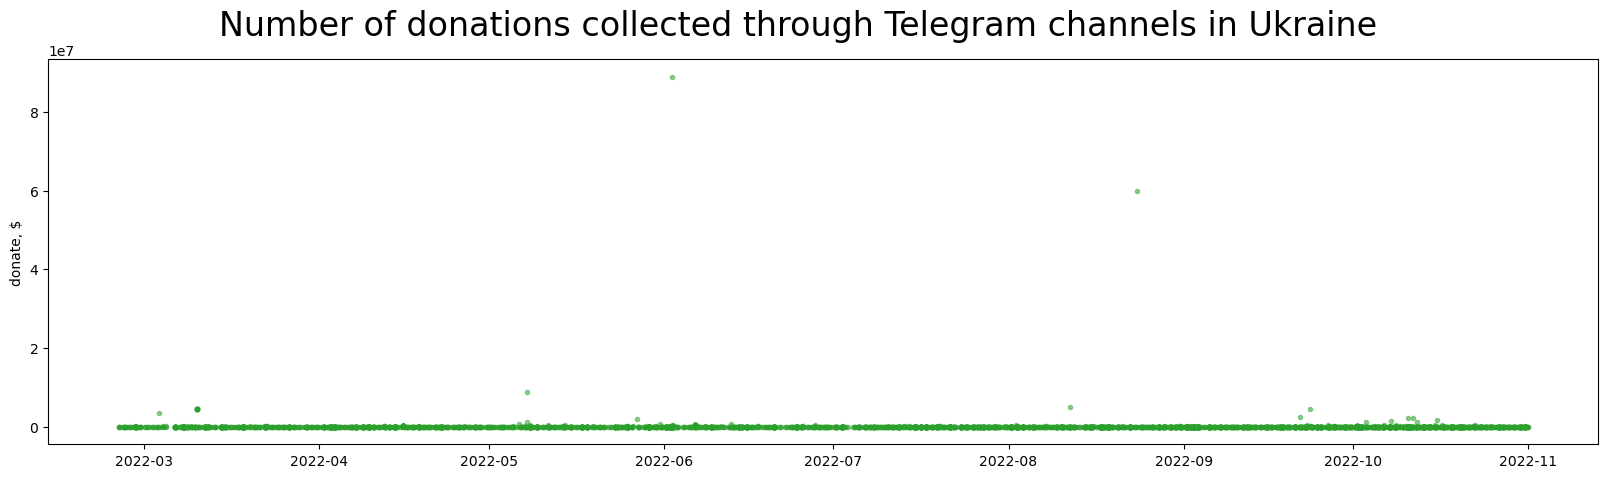

In [73]:
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
fig.suptitle("Number of donations collected through Telegram channels in Ukraine", fontsize=24)

axes.plot(final_Ukraine_df['final_donate'], marker='.', alpha=0.5, linestyle='None', color='#2ca02c')
axes.set_ylabel('donate, $')
fig.subplots_adjust(top=0.88)
plt.show()

In [74]:
final_Ukraine_df = final_Ukraine_df.reset_index()

In [77]:
donate_by_week_df = final_Ukraine_df.groupby([pd.Grouper(key='DateTime', freq='W')])['final_donate'].sum().copy()

In [78]:
donate_by_week_df = donate_by_week_df.reset_index()
donate_by_week_df.head(2)

,DateTime,final_donate
0,2022-02-27,2.342899e+05
1,2022-03-06,4.058278e+06


In [80]:
donate_by_week_df['DateTime']= pd.to_datetime(donate_by_week_df['DateTime'])

In [81]:
type(donate_by_week_df.iloc[0]['DateTime'])

pandas._libs.tslibs.timestamps.Timestamp

In [83]:
donate_by_week_df = donate_by_week_df.set_index('DateTime')
donate_by_week_df.head(2)

,final_donate
DateTime,
2022-02-27,2.342899e+05
2022-03-06,4.058278e+06


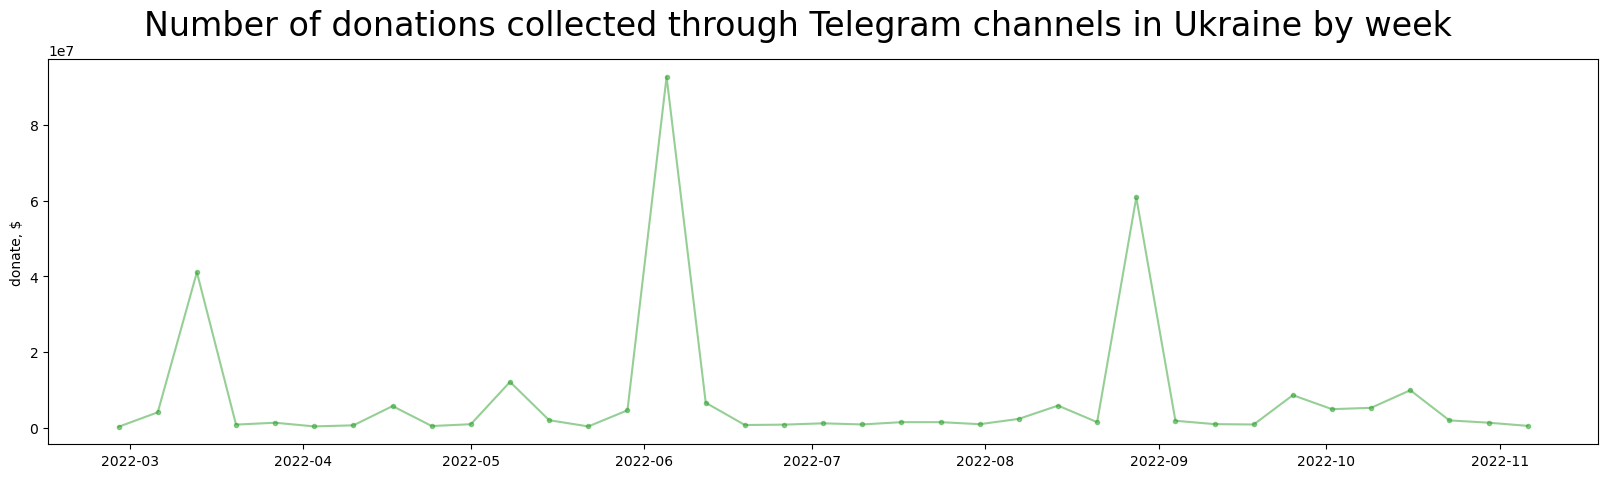

In [86]:
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
fig.suptitle("Number of donations collected through Telegram channels in Ukraine by week", fontsize=24)

axes.plot(donate_by_week_df, marker='.', alpha=0.5, color='#2ca02c') #  linestyle='None',
axes.set_ylabel('donate, $')
fig.subplots_adjust(top=0.88)
plt.show()
